<a id='top'></a>
# Signal Processing/Note Isolation

This notebook contains signal processing and machine learning techniques used to isolate notes, and create a labeled dataframe on which an instrument classifier can be trained.<br>

### Contents:
- [Setup](#setup)
- [Butterworth passband filter](#butter)
- [Fourer transform](#fourier)
- [Non-negative Matrix Factorization](#nmf)
- [Creating a DataFrame](#create)

<a id='setup'></a>
## Setup
[back to top](#top)<br>

The dataset I used can be found in the music/dataset/ directory. I placed the data in a dictionary, which I iterated through when creating the final dataframe.<br>

I imported a file, sound_check.py, which contains simple functions that can be used in an initial check of the wave files.

In [1]:
import os
import seaborn as sns
import pyaudio
import wave
import numpy as np

from scipy.signal import butter, lfilter, spectrogram
from scipy.fftpack import fft, ifft, rfft, irfft, fftfreq,  rfftfreq

from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd
from copy import deepcopy

import pandas as pd
import pickle

%matplotlib inline

In [2]:
# Instruments & Notes
# all sampled at 44100 Hz, 16000 bits per sample, mono

path = os.getcwd()+'/music'

inst_dict = {}
for (root,dirs,files) in os.walk(path+'/dataset'):
    files = [f for f in files if not f[0] == '.']
    dirs = [d for d in dirs if not d[0] == '.']
    if files:
        inst_dict[root.split('/')[-1]] = [root + '/' + f for f in files]

test_audio = ["/piano/notes/C4.wav",
              "/piano/playing/playing_001.wav",
              "/dataset/flute/C4_E4.wav",
              "/dataset/piano/C4_E4.wav",
             ]

lowcut = 20
highcut = 16000

In [3]:
inst_dict

{'flute': ['/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/C4_A4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/C4_E4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/C4_F4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/C4_G4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/E4_A4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/E4_F4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/E4_G4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/F4_A4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/F4_G4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/flute/G4_A4.wav'],
 'piano': ['/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/C4_A4.wav',
  '/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/C4_E4.wav',
  '/Users

In [4]:
# %load sound_check.py
# Helper/initial check functions
# run cell twice when loading in a jupyter notebook, and use: %load kojak_helpers.py

import pyaudio
import wave
import numpy as np
from scipy.signal import butter, lfilter


# Play a wav file
def play_wav(file,path=None):
    file = path+file if path else file
    print("Playing: ", file)
    chunk = 1024//2
    f = wave.open(file,"rb")
    p = pyaudio.PyAudio()
    stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                    channels = f.getnchannels(),  
                    rate = f.getframerate(),  
                    output = True)
    data = f.readframes(chunk)
    while data:  
        stream.write(data)  
        data = f.readframes(chunk)
    stream.stop_stream()  
    stream.close()    
    p.terminate()


# Convert stereo tracks to mono
def ster_to_mon(frames):
    frames = frames[:-1] if len(frames)%2>0 else frames
    newaudiodata = []
    for i in range(0,len(frames),2):
        d = (frames[i] + frames[i+1])/2
        newaudiodata.append(d)
    return np.array(newaudiodata, dtype='int16')


# Opens wav file
def open_wav(file,path=None):
    file = path+file if path else file
    print("Opening file: ",file)
    f = wave.open(file, "rb")
    frames = np.fromstring(f.readframes(-1), 'Int16')
    frames = ster_to_mon(frames) if f.getnchannels()==2 else frames
    rate = f.getframerate()
    f.close()
    print("Time (s): ", len(frames)/rate)
    return frames, rate

# Simple plot of wav file
def quickplot_wav(file,path=None):
    frames, rate = open_wav(file,path=path)
    times = [(x[0]/rate) for x in list(enumerate(frames))]
    sns.plt.figure()
    sns.plt.title('Signal Wave')
    sns.plt.xlabel("Time")
    sns.plt.ylabel("Amplitude")
    sns.plt.plot(times,frames)
    sns.plt.show()


In [5]:
play_wav(inst_dict['piano'][0])

Playing:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/C4_A4.wav


<a id='butter'></a>
## Butterworth passband filter
[back to top](#top)<br>

Butterworth filter implemented as an option when obtaining frames from a wave file.<br>

The filter used in this project filtered out frequencies below 20 Hz and above 16,000 Hz.<br>

In [6]:
# Butterworth passband filter (can be visualized with 'plot_wav' function)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = lfilter(b, a, data)
    return filtered

In [7]:
# Use this function to get all the frames from a song. Will use those frames to create a matrix with fft

def get_frames(file,start=None,stop=None,butter=False,lowcut=lowcut,highcut=highcut,plot=False,path=None):
    frames, rate = open_wav(file,path=path)
    
    if butter==True:
        frames = butter_bandpass_filter(frames, lowcut, highcut, rate, order=2)

    start = 0 if start==None else start
    stop = len(frames) if stop==None else stop
    
    frames = frames[int(start*rate):int(stop*rate)]
    times = [(x[0]/rate) for x in list(enumerate(frames))]
    
    if plot==True:
        sns.plt.figure(1)
        sns.plt.title('Signal Wave')
        sns.plt.xlabel("Time")
        sns.plt.ylabel("Amplitude")
        sns.plt.plot(times,frames)
        sns.plt.show()
    
    return frames, rate

#get_frames(test_audio[0],butter=True,plot=True,path=path)

Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/playing/playing_001.wav
Time (s):  5.175600907029478


/Users/kevin_katzmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


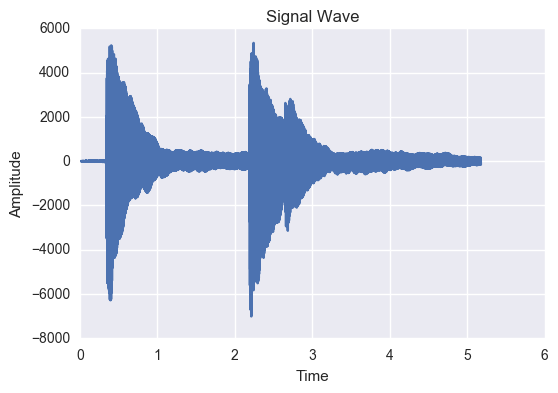

In [8]:
test_frames, test_rate = get_frames(test_audio[1],butter=True,plot=True,path=path)

<a id='fourier'></a>
## Fourier transform
[back to top](#top)</br>

The goal of this section is to create a matrix composed of multiple Fourier transforms across the length of the frames.</br>

Doing so will yield a matrix of m time-windows by n frequencies (M×N), with each point representing the magnitude of a frequency, throughout a window of time.</br>

Window length was set at 1/4 seconds.
- need window to be large enough to precicely capture the frecuencies that are present, but small enough to capture temporal information as it traverses the length of the frames
- 1/4 second windows are work perfectly fine for the purposes of this trial, but use of smaller windows should be considered as songs become more complex, and more 'real'</br>

Spectrogram included to vizualize the matrix.<br>


In [9]:
def fft(frames,rate,window=(1/4),freq_req=True):
    # adjust for odd length of frames (issue will show up when  by 1/4 sec, 1/8 sec, etc.)
    frames = frames[:-1] if len(frames)%2!=0 else frames
    
    n = len(frames)
    unique = n//2
    
    amp = np.abs(rfft(frames)[:unique])
    freq = np.abs(fftfreq(n,d=((window)/(unique)))[:unique])
        
    if freq_req==True:
        return amp, freq
    else:
        return amp

In [10]:
def fft_matrix(frames,rate,window=(1/4)):

    amps = []
    times = []
    start = 0
    time=0
    
    while True:
        end = start + window*rate
        if end > len(frames):
            break
        current_frames = frames[int(start):int(end)]
        
        current_amps, current_freqs = fft(current_frames,rate,window=window)
        
        amps.append(current_amps)
        if time==0:
            freqs = current_freqs
        times.append(time)
        
        start = end
        time += window
        
    return amps, freqs, times


In [11]:
test_amps, test_freqs, test_times = fft_matrix(test_frames,test_rate)

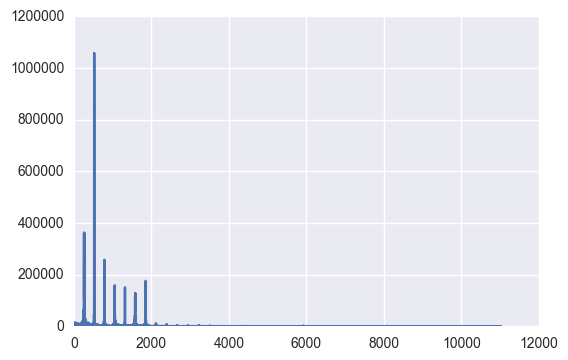

In [12]:
sns.plt.plot(test_freqs,test_amps[6])

In [13]:
len(test_freqs)

5512

In [16]:
# Spectrogram
# Adjust vmin/vmax to adjust intensity of colors.

def spect(amp_matrix, times, min_freq=0, max_freq=5000, vmin=0, vmax=100000):
    fig = sns.plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(np.transpose(np.array(amp_matrix)),aspect='auto',cmap='plasma',vmin=vmin,vmax=vmax)
    sns.plt.grid(b=None)
    
    yticks = ax.get_yticks()[1:-1]
    sns.plt.yticks(yticks, (yticks * max_freq/yticks[-1]).astype('str'))
    sns.plt.ylim(max_freq,min_freq)
    
    sns.plt.xticks(np.arange(0,len(times),1), [x*1 for x in times])
    
    sns.plt.ylabel('frequency')
    sns.plt.xlabel('time')
    sns.plt.show()

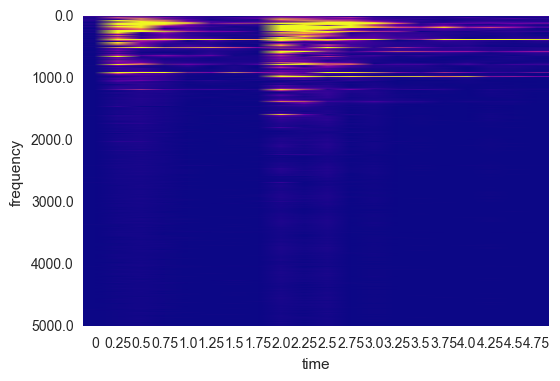

In [17]:
spect(test_amps,test_times)

Functions seem to work.<br>

You can clearly see the two louder notes being played in the spectrogram.<br>

The first note (C4) is played between 0 and 0.25 seconds.<br>
The second note (G4) is played between 1.75 and 2.0 seconds.<br>
A third note (C4) is played more softly, just after the second, between 2.25 and 2.5 seconds<br>

Now lets put matrix through NMF to isolate notes...<br>

<a id='nmf'></a>
## Non-negative Matrix Factorization
[back to top](#top)<br>

The goal of this section is to isolate individual notes.<br>

For this project, I will be parsing each 'song' into 5 intervals, and performing an Fourier transform on 1/4 windows of those intervals, yielding 20 time windows per interval.<br>

I will then perform NMF the matrix acquired from each interval (20×5512), to isolate the two notes, or two 'clusters of frequencies' (main frequency of note, and its overtones), that are present.<br>

Automation of this process would require identifying the number of notes played in a parsed interval. SVD could be used for this, but might not be the best option.


In [18]:
# Helpers for nmf_test

def select_instrument(W,instrument_index):
    muted = deepcopy(W)
    for i in muted:
        for j in range(len(i)):
            if j!=instrument_index:
                i[j]=0
    return muted

def reconstruct(instrument_matrix):
    instrument_frames = []
    for fft in instrument_matrix:
        fft_list=list(fft)
        fft_list.extend(fft_list[::-1])
        instrument_frames.extend(irfft(fft_list))
    return instrument_frames

def plot_svd(amp_matrix, n):
    U, S, T = randomized_svd(np.array(amp_matrix), n_components=n, n_iter=7, random_state=42)
    print(S)
    sns.plt.figure()
    sns.plt.plot(S)
    sns.plt.show()

In [19]:
# Useful function for visualizing separation of the notes

def nmf_viz(amps, freqs, times, n_notes, plot=False, eigen=10):
    nmf = NMF(n_components=n_notes, init='random', random_state=0)
    W = nmf.fit_transform(amps)
    H = nmf.components_;
    instrument_arrays = []
    if plot==True:
        plot_svd(amps,eigen)
    for i in range(n_notes):
        selected = select_instrument(W,i)
        instrument = nmf.inverse_transform(selected)
        frames = reconstruct(instrument)
        instrument_arrays.append(np.array(frames))
        if plot==True:
            sns.plt.figure()
            sns.plt.plot(frames)
            sns.plt.show()
    return instrument_arrays

[ 24289112.00215494  19808824.53549099  10608731.40537097
   9108571.59554976   6221890.97838761   2910136.03178484
   2017565.25993811   1507224.52159954   1412601.11047857
   1102090.42511223]


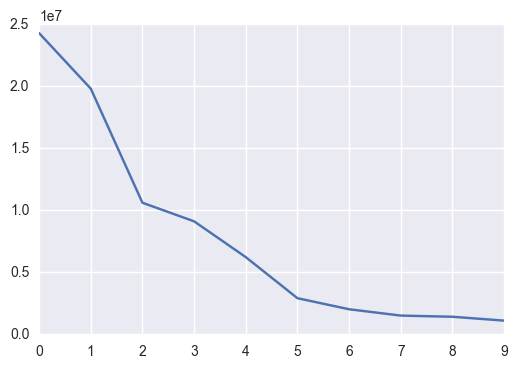

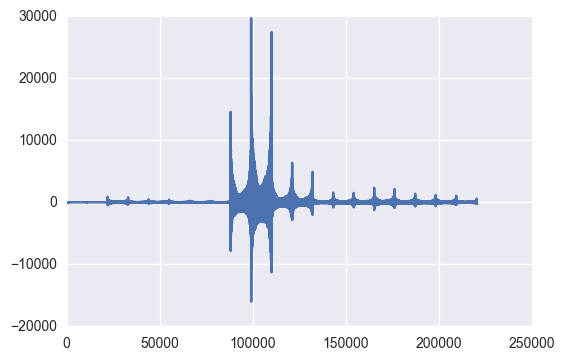

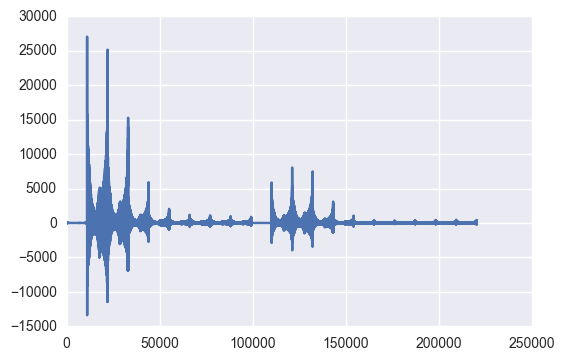

[array([  1.12994604e+01,  -1.41957918e-01,   1.01486216e+01, ...,
          2.89819496e+02,   5.73754055e+02,   1.64410739e+02]),
 array([  1.16682620e+01,  -3.31268486e-01,   1.08317132e+01, ...,
          1.51339058e+02,   4.25611046e+02,   8.77008470e+01])]

In [20]:
# The reconstructed plot is a bit off because I used only the second half of the absolute values of the Fourier.
# But relative amplitudes among the 1/4 sec windows remain true.

nmf_viz(test_amps, test_freqs, test_times, 2, plot=True)

In [21]:
# NMF function used to create the dataframe. This will return a row for each note, which includes:
#   - the instrument
#   - temporal information of the cluster (column in the W matrix)
#   - overtones (corresponding row in the H matrix).

def nmf_isolate(amp_matrix, n_notes, inst_type=None):
    nmf = NMF(n_components=n_notes, init='random', random_state=0)
    W = nmf.fit_transform(amp_matrix)
    H = nmf.components_
    note_arrays = []
    
    for i in range(n_notes):
        note = [inst_type]
        Wi = [x[i] for x in W]
        note.extend(Wi)
        note.extend(H[i])
        note_arrays.append(note)

    return note_arrays

In [22]:
# Parse frames of a song into smaller intervals (5 seconds for my case) so that SVD can
#   more easily identify number of notes (or clusters of frequencies) present, and NMF 
#   can more easily separate them

def parse_frames(frames,rate,interval=5):
    frames_list = []
    intvl = int(interval*rate)
    intvl_end = intvl
    start = 0
    while True:
        if intvl_end>len(frames):
            return frames_list
        frames_list.append(frames[start:intvl_end])
        start=intvl_end
        intvl_end+=intvl


<a id='create'></a>
## Creating DataFrame
[back to top](#top)<br>

Create a labeled dataframe, containing the temporal and overtone information of each note

In [23]:
# Now combine everything to create dataframe to train classifier on, starting with dict.
def create_df(inst_dict, parse_interval=5, fft_window=(1/4)):
    note_arrays = []
    instruments = list(inst_dict.keys())
    for inst in instruments:
        print("Instrument: ",inst)
        for song in inst_dict[inst]:
            frames, rate = get_frames(song,butter=True,)
            parsed_frames = parse_frames(frames,rate,interval=parse_interval)
            for frame in parsed_frames:
                amps, freqs, times = fft_matrix(frame,rate,window=fft_window)
                isolated = nmf_isolate(test_amps,2,"piano")
                note_arrays += isolated
            if song == inst_dict[inst][0] and inst == instruments[0]:
                cols = ["instrument"]
                freq_cols = [str(x)+" Hz" for x in list(freqs)]
                cols.extend(freq_cols)
                time_cols = [str(x)+"+ s" for x in times]
                cols.extend(time_cols)
    df = pd.DataFrame(note_arrays, columns=cols)
    return df

In [24]:
%%time
df = create_df(inst_dict)

Instrument:  piano
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/C4_A4.wav
Time (s):  122.47927437641724


/Users/kevin_katzmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/C4_E4.wav
Time (s):  121.93614512471655
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/C4_F4.wav
Time (s):  124.65185941043084
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/C4_G4.wav
Time (s):  123.56557823129252
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/E4_A4.wav
Time (s):  123.02242630385487
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/E4_F4.wav
Time (s):  122.75086167800454
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/E4_G4.wav
Time (s):  121.93614512471655
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/F4_A4.wav
Time (s):  123.02242630385487
Opening file:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/dataset/piano/F4_G4.wav
Time (s):  122.59369614512471
Opening file:  /Users/kevin_katz

In [25]:
df.head()

,instrument,0.0 Hz,2.0 Hz,4.0 Hz,6.0 Hz,8.0 Hz,10.0 Hz,12.0 Hz,14.0 Hz,16.0 Hz,...,2.5+ s,2.75+ s,3.0+ s,3.25+ s,3.5+ s,3.75+ s,4.0+ s,4.25+ s,4.5+ s,4.75+ s
0,piano,0.188659,0.000000,14.462608,5.794117,7.788014,4.208870,3.763329,3.490718,243.415361,...,2.508654,2.307055,2.486311,2.454263,2.037899,1.830852,2.558858,1.927958,2.846597,2.120292
1,piano,0.426600,988.469666,600.288256,232.375840,80.226762,36.776741,43.334542,38.438236,34.722463,...,0.918194,1.212275,0.894884,1.175351,0.942144,1.117591,0.649042,0.914750,0.744140,0.867145
2,piano,0.188659,0.000000,14.462608,5.794117,7.788014,4.208870,3.763329,3.490718,243.415361,...,2.508654,2.307055,2.486311,2.454263,2.037899,1.830852,2.558858,1.927958,2.846597,2.120292
3,piano,0.426600,988.469666,600.288256,232.375840,80.226762,36.776741,43.334542,38.438236,34.722463,...,0.918194,1.212275,0.894884,1.175351,0.942144,1.117591,0.649042,0.914750,0.744140,0.867145
4,piano,0.188659,0.000000,14.462608,5.794117,7.788014,4.208870,3.763329,3.490718,243.415361,...,2.508654,2.307055,2.486311,2.454263,2.037899,1.830852,2.558858,1.927958,2.846597,2.120292


In [26]:
# Pickling
# Un-comment to either re-write or open 'instrument_df.pkl'

# Writing
#with open('instrument_df.pkl', 'wb') as picklefile:
#    pickle.dump(df, picklefile)

# Opening
#with open('instrument_df.pkl', 'rb') as picklefile: 
#    df = pickle.load(picklefile)